# Import relevant libraries

In [47]:
#set up
import json
import gzip
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime
from scipy import stats

plt.style.use('fivethirtyeight')

# Read data

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for i in g:
        yield json.loads(i)
        
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient = 'index')

In [4]:
ab_r = getDF('All_Beauty.json.gz')
ab_m = getDF('meta_All_Beauty.json.gz')
lb_r = getDF('Luxury_Beauty.json.gz')
lb_m = getDF('meta_Luxury_Beauty.json.gz')

In [5]:
# merge the data

ab_merged = pd.merge(ab_r, ab_m, how='inner', on ='asin')
lb_merged = pd.merge(lb_r, lb_m, how='inner', on ='asin')

# Data Cleaning

In [7]:
# data cleaning
to_drop = ['vote','reviewText', 'reviewerName', 'summary','image_x', 'image_y', 'description', 'details']
ab_merged.drop(to_drop, inplace=True, axis=1)
lb_merged.drop(to_drop, inplace=True, axis=1)

In [8]:
## drop NaN

lb_merged_non = lb_merged.dropna(subset=['price'])
ab_merged_non = ab_merged.dropna(subset=['price'])

In [441]:
## Convert unixReviewTime to the datetime
ab_merged_non['DatetimeIndex'] = pd.to_datetime(ab_merged_non['unixReviewTime'],unit='s')
lb_merged_non['DatetimeIndex'] = pd.to_datetime(lb_merged_non['unixReviewTime'],unit='s')

C:\Users\Tunky\Anaconda3\envs\smn635\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Tunky\Anaconda3\envs\smn635\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [512]:
## build a conver_currency function
def conver_currency(value):
    """
    =============================
    Argument: string
    convert currency 
    - remove $
    - convert string to float
    
    Return: float
    =============================
    
    """
    new_value = value.replace(',','').replace('$','')
    return np.float(new_value)

## build a to float function
def to_float(x):
    return np.float(x)

## build a function to remove outliers
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.05)
    q3 = df_in[col_name].quantile(0.95)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#Identify outliers
def detect_outlier(data_1):
    outliers=[]
    threshold=4
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Tunky\Anaconda3\envs\smn635\lib\site-packages\pandas\core\nanops.py", line 120, in f
    result = alt(values, axis=axis, skipna=skipna, **kwds)
  File "C:\Users\Tunky\Anaconda3\envs\smn635\lib\site-packages\pandas\core\nanops.py", line 551, in nanmean
    the_sum = _ensure_numeric(values.sum(axis, dtype=dtype_sum))
  File "C:\Users\Tunky\Anaconda3\envs\smn635\lib\site-packages\numpy\core\_methods.py", line 36, in _sum
    return umr_sum(a, axis, dtype, out, keepdims, initial)
TypeError: can only concatenate list (not "int") to list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Tunky\Anaconda3\envs\smn635\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-513-4588a7e9e0f7>", line 1, in <module>
    detect_outlier(df_ab)
  File "<ipython-input-512-6070b661721b>"

TypeError: can only concatenate str (not "list") to str

In [443]:
## convert string to float
ab_merged_non['price'] = ab_merged_non['price'].apply(conver_currency)
lb_merged_non['price'] = lb_merged_non['price'].apply(conver_currency)

# Due to one of the lines having a range in price, namely '12.90 - 169.95', the function skips this value
## Maybe we can try to drop these values

ValueError: could not convert string to float: '12.90 - 169.95'

## extract products that have reviews over 6 months

In [444]:
# Find the lastest date
lb_edate = min(lb_merged_non['DatetimeIndex'])
lb_ldate = max(lb_merged_non['DatetimeIndex'])
lb_threshold = lb_ldate - datetime.timedelta(days=180)
ab_edate = min(ab_merged_non['DatetimeIndex'])
ab_ldate = max(ab_merged_non['DatetimeIndex'])
ab_threshold = ab_ldate - datetime.timedelta(days=180)

In [445]:
# creat start_date and end_date column 
ab_sdate = ab_merged_non.groupby(by=['asin'], as_index=False)['DatetimeIndex'].min()
ab_sdate.rename(columns={'DatetimeIndex': 'start_date'}, inplace=True)
lb_sdate = lb_merged_non.groupby(by=['asin'], as_index=False)['DatetimeIndex'].min()
lb_sdate.rename(columns={'DatetimeIndex': 'start_date'}, inplace=True)

In [ ]:
# Defining and applying 6 months time span
cal_6months = lambda x: (x+ datetime.timedelta(days=180))
ab_sdate['end_date'] = ab_sdate['start_date'].apply(cal_6months)
lb_sdate['end_date'] = lb_sdate['start_date'].apply(cal_6months)

In [447]:
# merge the dataframe 
df_lb = pd.merge(lb_merged_non, lb_sdate, how='inner', on ='asin')
df_ab = pd.merge(ab_merged_non, ab_sdate, how='inner', on ='asin')

In [448]:
# Exclude products whose first score has been posted by less than six months
df_lb = df_lb[df_lb['start_date'] < lb_threshold]
df_ab = df_ab[df_ab['start_date'] < ab_threshold]

In [449]:
# the very first reviews up to six months later
df_lb = df_lb[df_lb['DatetimeIndex'] < df_lb['end_date']]
df_ab = df_ab[df_ab['DatetimeIndex'] < df_ab['end_date']]


In [450]:
# Calculate difference in days between first and last review of each product
df_lb['#Days'] = df_lb['DatetimeIndex'] - df_lb['start_date']
df_lb['#Days'] = df_lb['#Days'].apply(lambda x: x.days)
df_ab['#Days'] = df_ab['DatetimeIndex'] - df_ab['start_date']
df_ab['#Days'] = df_ab['#Days'].apply(lambda x: x.days)

In [451]:
#Max date within 6 months
series_lb = df_lb.groupby(by=['asin'], as_index=False)['DatetimeIndex'].max()
series_lb.rename(columns={'DatetimeIndex': 'last_review'}, inplace=True)
series_ab = df_ab.groupby(by=['asin'], as_index=False)['DatetimeIndex'].max()
series_ab.rename(columns={'DatetimeIndex': 'last_review'}, inplace=True)

df_lb = pd.merge(df_lb, series_lb, how='inner', on ='asin')
df_ab = pd.merge(df_ab, series_ab, how='inner', on ='asin')

# calculate between first review and last reviws
df_lb['review_gap'] = df_lb['last_review'] - df_lb['start_date']
df_lb['review_gap'] = df_lb['review_gap'].apply(lambda x: x.days)
df_ab['review_gap'] = df_ab['last_review'] - df_ab['start_date']
df_ab['review_gap'] = df_ab['review_gap'].apply(lambda x: x.days)

In [454]:
#dataset for plot 4
df4_lb=pd.DataFrame(df_lb.groupby(by=['asin','review_gap'],as_index=False)['overall'].count())
df4_ab=pd.DataFrame(df_ab.groupby(by=['asin','review_gap'],as_index=False)['overall'].count())

In [455]:
# Calculate average pace based on the gap between first and last review and number of reviews in that period
df4_lb['average pace']=df4_lb['review_gap']/df4_lb['overall']
df4_ab['average pace']=df4_ab['review_gap']/df4_ab['overall']
# Round average pace in order to group the data for the average trend line
df4_lb['round avg pace'] = df4_lb['average pace'].round()
df4_ab['round avg pace'] = df4_ab['average pace'].round()
df4_lb_avg = pd.DataFrame(df4_lb.groupby(by=['round avg pace'], as_index=False)['overall'].aggregate(np.sum))
df4_ab_avg = pd.DataFrame(df4_ab.groupby(by=['round avg pace'], as_index=False)['overall'].aggregate(np.sum))
# Temporary Dataframe
df4_lb_com = df4_lb.groupby(by=['round avg pace'], as_index=False)['overall'].count()
df4_ab_com = df4_ab.groupby(by=['round avg pace'], as_index=False)['overall'].count()
# Convert int to float
df4_lb_avg['round avg pace'] = df4_lb_avg['round avg pace'].apply(to_float)
df4_ab_avg['round avg pace'] = df4_ab_avg['round avg pace'].apply(to_float)

In [481]:
df4_ab_com

,round avg pace,overall
0,0.0,6441
1,1.0,28
2,2.0,52
3,3.0,46
4,4.0,71
...,...,...
86,86.0,31
87,87.0,8
88,88.0,21
89,89.0,7


In [457]:
# Calculate average number of reviews per product to use in showing general trend
df4_lb_avg['average count']=df4_lb_avg['overall']/df4_lb_com['overall']
df4_ab_avg['average count']=df4_ab_avg['overall']/df4_ab_com['overall']

In [459]:
# Calculating number of weeks to use as x axis for visualisation
df_lb['#Weeks'] = df_lb['#Days'].apply(lambda x: int(x/7))
df_ab['#Weeks'] = df_ab['#Days'].apply(lambda x: int(x/7))

In [460]:
# set the datetime as indext
df_lb.set_index('DatetimeIndex', inplace=True)
df_ab.set_index('DatetimeIndex', inplace=True)
# Groupby 
df_lb_g=pd.DataFrame(df_lb.groupby(['asin','#Weeks'])['overall'].count())
df_ab_g=pd.DataFrame(df_ab.groupby(['asin','#Weeks'])['overall'].count())

In [504]:
# Fill NaN with 0 and then replace with 'No brand'
df_ab['brand']=df_ab['brand'].fillna(value= 0)
df_lb['brand']=df_lb['brand'].fillna(value= 0)
df_ab['brand']=df_ab['brand'].replace(0, 'No brand')
df_lb['brand']=df_lb['brand'].replace(0, 'No brand')
df_lb

,overall,verified,reviewTime,reviewerID,asin,unixReviewTime,style,title,also_buy,rank,...,main_cat,price,brand,feature,start_date,end_date,#Days,last_review,review_gap,#Weeks
DatetimeIndex,,,,,,,,,,,,,,,,,,,,,
2010-06-15,2.0,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,1276560000,NaN,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324inBeautyPersonalCare(",...,Luxury Beauty,$30.00,No brand,NaN,2010-01-07,2010-07-06,159,2010-06-15,159,22
2010-06-15,2.0,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,1276560000,NaN,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324inBeautyPersonalCare(",...,Luxury Beauty,$30.00,No brand,NaN,2010-01-07,2010-07-06,159,2010-06-15,159,22
2010-01-07,5.0,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,1262822400,NaN,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324inBeautyPersonalCare(",...,Luxury Beauty,$30.00,No brand,NaN,2010-01-07,2010-07-06,0,2010-06-15,159,0
2010-01-07,5.0,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,1262822400,NaN,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...","4,324inBeautyPersonalCare(",...,Luxury Beauty,$30.00,No brand,NaN,2010-01-07,2010-07-06,0,2010-06-15,159,0
2013-04-22,4.0,True,"04 22, 2013",A3TXIN5QWZMHCH,B00005A77F,1366588800,NaN,"Crabtree & Evelyn Hand Soap, Gardeners, 10.1 f...",NaN,NaN,...,Luxury Beauty,$15.99,No brand,NaN,2012-10-31,2013-04-29,173,2013-04-22,173,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-21,3.0,True,"07 21, 2017",A1UKPVDCE6VGN,B01HIIO7Q4,1500595200,{'Size:': ' 1.6 fl. oz.'},Klorane Conditioner with Pomegranate - Color-T...,"[B01KLCQV90, B000A408T4, B002KPE8W4, B01LWLCZZ...","139,076inBeautyPersonalCare(",...,Luxury Beauty,$20.00,No brand,NaN,2017-02-01,2017-07-31,170,2017-07-21,170,24
2017-04-15,5.0,True,"04 15, 2017",AOUIF4QULQVXO,B01HIIO7Q4,1492214400,{'Size:': ' 6.7 fl. oz.'},Klorane Conditioner with Pomegranate - Color-T...,"[B01KLCQV90, B000A408T4, B002KPE8W4, B01LWLCZZ...","139,076inBeautyPersonalCare(",...,Luxury Beauty,$20.00,No brand,NaN,2017-02-01,2017-07-31,73,2017-07-21,170,10
2017-02-01,3.0,True,"02 1, 2017",AY8WT4WMDDUX0,B01HIIO7Q4,1485907200,{'Size:': ' 1.6 fl. oz.'},Klorane Conditioner with Pomegranate - Color-T...,"[B01KLCQV90, B000A408T4, B002KPE8W4, B01LWLCZZ...","139,076inBeautyPersonalCare(",...,Luxury Beauty,$20.00,No brand,NaN,2017-02-01,2017-07-31,0,2017-07-21,170,0


In [506]:
# Create a new dataframe which measures the strength of each brand, namely number of reviews per brand
lb_brand=pd.DataFrame(df_lb.groupby(['brand','asin'])['overall'].count())
ab_brand=pd.DataFrame(df_ab.groupby(['brand','asin'])['overall'].count())
lb_brand = lb_brand.sort_values(by='overall', ascending=False)
ab_brand = ab_brand.sort_values(by='overall', ascending=False)
ab_brand

,overall
brand,
No brand,7905
Italia-Deluxe,502
VAGA,447
OZ Naturals,290
TOULON,256
...,...
Mott's,1
MothPro,1
Mosbeau,1


In [463]:
#Reset index
df_lb_g.reset_index(inplace=True)
df_ab_g.reset_index(inplace=True)

In [464]:
# Prepared data in order to be able to remove outliers
df3_ab = df_ab_g.sort_values(by='overall')
df3_ab['overall']=df3_ab['overall'].apply(to_float)
df3_lb = df_lb_g.sort_values(by='overall')
df3_lb['overall']=df3_lb['overall'].apply(to_float)
df3_ab.reset_index(inplace=True)
df3_lb.reset_index(inplace=True)

In [465]:
# Remove outliers
df3_ab = remove_outlier(df3_ab,'overall')
df3_lb = remove_outlier(df3_lb,'overall')
df4_ab = remove_outlier(df4_ab,'overall')
df4_lb = remove_outlier(df4_lb,'overall')

In [487]:
df4_ab

,asin,review_gap,overall,average pace,round avg pace
0,014789302X,132,5,26.40,26.0
1,0977217213,0,1,0.00,0.0
2,0977217221,0,1,0.00,0.0
3,0982629281,0,1,0.00,0.0
4,1592723721,0,1,0.00,0.0
...,...,...,...,...,...
10876,B01HIM3A3G,0,1,0.00,0.0
10878,B01HIUEEHO,100,4,25.00,25.0
10879,B01HIWLLUK,0,1,0.00,0.0
10880,B01HJ84SGM,147,4,36.75,37.0


<function matplotlib.pyplot.show(*args, **kw)>

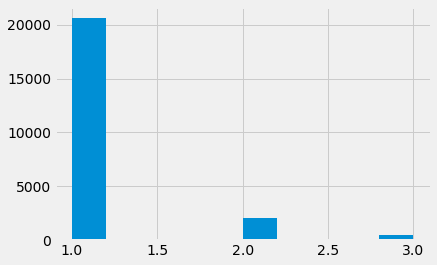

In [467]:
# I was trying to test the normality of our raw data, but well it seems more like a Poisson distribution
plt.hist(df3_ab['overall'])
plt.show

In [468]:
# I was trying to test the normality of our raw data, but well it seems more like a Poisson distribution
'''
k2, p = stats.shapiro(df_ab_g['overall'])
print(format(k2), format(p))
alpha=0.001
if float(format(p)) < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
'''

'\nk2, p = stats.shapiro(df_ab_g[\'overall\'])\nprint(format(k2), format(p))\nalpha=0.001\nif float(format(p)) < alpha:  # null hypothesis: x comes from a normal distribution\n    print("The null hypothesis can be rejected")\nelse:\n    print("The null hypothesis cannot be rejected")\n'

In [469]:
# I was trying to test the normality of our raw data, but well it seems more like a Poisson distribution
'''
len(detect_outlier(df_ab_g['overall']))
index_names = np.where(ab_z>4).index_names
df_ab_g.drop(index_names, inplace=True)
df_ab_g = df_ab_g[(np.abs(stats.zscore(df_ab_g['overall'])) < 4 ).all(axis=1)]
df_lb_g = df_lb_g[(np.abs(stats.zscore(df_lb_g['overall'])) < 4 ).all(axis=1)]
'''

"\nlen(detect_outlier(df_ab_g['overall']))\nindex_names = np.where(ab_z>4).index_names\ndf_ab_g.drop(index_names, inplace=True)\ndf_ab_g = df_ab_g[(np.abs(stats.zscore(df_ab_g['overall'])) < 4 ).all(axis=1)]\ndf_lb_g = df_lb_g[(np.abs(stats.zscore(df_lb_g['overall'])) < 4 ).all(axis=1)]\n"

In [470]:
# Temporary dataframes to use for average calculation for dataframes a and b
df_lb_avg = pd.DataFrame(df3_lb.groupby('#Weeks')['overall'].count())
df_ab_avg = pd.DataFrame(df3_ab.groupby('#Weeks')['overall'].count())

In [471]:
# Main dataframes to use for plot 1 and 2
a = pd.DataFrame(df3_lb.groupby('#Weeks')['overall'].aggregate(np.sum))
b = pd.DataFrame(df3_ab.groupby('#Weeks')['overall'].aggregate(np.sum))

In [472]:
# Calculate and add average column
a.loc[:,'avg'] = a['overall'] / df_lb_avg['overall'] 
b.loc[:,'avg'] = b['overall'] / df_ab_avg['overall']

In [473]:
# Convert values in overall to float so we can plot them
a['overall']=a['overall'].apply(to_float)
b['overall']=b['overall'].apply(to_float)

In [474]:
# Reset index for a and b for esthetic reasons
a.reset_index(inplace=True)
b.reset_index(inplace=True)

In [475]:
# Add cumulative sum column to plot a trajectory of an average product in both categories
a.loc[:,'cumsum']=a['avg'].transform(np.cumsum)
b.loc[:,'cumsum']=b['avg'].transform(np.cumsum)

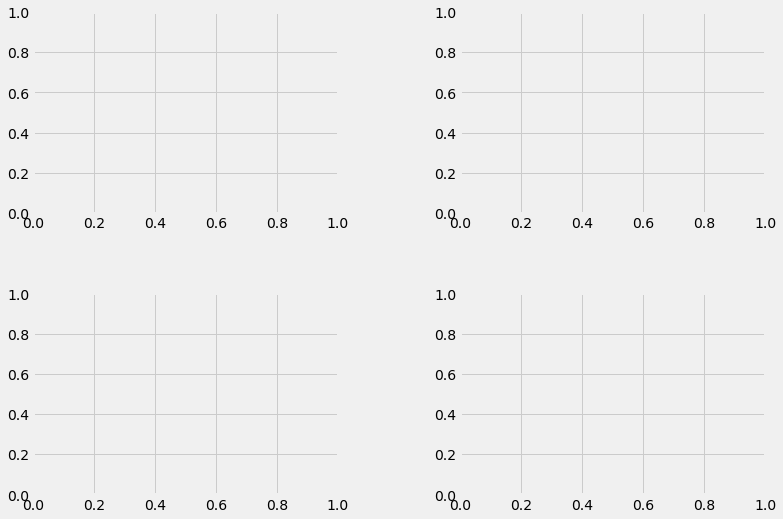

In [507]:
#Figure creation
fig = plt.figure(figsize=(11.69,8.27)) #figure size in inches to fit A4

# parition the figure into 4 subplots with 'gridspec'
gs = gridspec.GridSpec(2, 2, # we want 2 rows, 2 cols
                       figure=fig, # this gs applies to figure
                       hspace=0.4, wspace=0.4, # separation between plots
                       width_ratios=[1, 1], # ration between the first and second column
                       height_ratios=[1, 1]) # ration between the first ans second row

# add plots
ax0 = fig.add_subplot(gs[0, 0]) # this will occupy the first row-first colum
ax1 = fig.add_subplot(gs[0, 1]) # and so on and so forth...
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

In [508]:
#Plot 1
ax0.plot('#Weeks','overall',data=df3_lb,
         color='red',
         alpha=0.5,
         linewidth=0.2)
ax0.plot('#Weeks','overall',data=df3_ab,
         color='green',
         alpha=0.5,
         linewidth=0.2)

ax0.plot('#Weeks','avg',data=a,
         color='orange',
         alpha=1,
         marker='o',
         linewidth=1)
ax0.plot('#Weeks','avg',data=b,
         color='blue',
         alpha=1,
         marker='^',
         linewidth=1)


In [509]:
# Plot2
ax1.plot('cumsum', data=a,
         color='orange',
         alpha=1,
         marker='^',
         linewidth=1)
ax1.plot('cumsum', data=b,
         color='blue',
         alpha=1,
         marker='o',
         linewidth=1)

In [510]:
#Plot 4 - Association between count of ratings and average pacing between reviews
ax3.plot('average pace','overall',data=df4_lb,
         color='green',
         alpha=0.5,
         linewidth=0.2)
ax3.plot('average pace','overall',data=df4_ab,
         color='orange',
         alpha=0.5,
         linewidth=0.2)
# The average trend is not really representative right now
'''
ax3.plot('round avg pace','average count',data=df4_lb_avg,
         color='red',
         alpha=1,
         linewidth=1)
ax3.plot('round avg pace','average count',data=df4_ab_avg,
         color='blue',
         alpha=1,
         linewidth=1)
'''


"\nax3.plot('round avg pace','average count',data=df4_lb_avg,\n         color='red',\n         alpha=1,\n         linewidth=1)\nax3.plot('round avg pace','average count',data=df4_ab_avg,\n         color='blue',\n         alpha=1,\n         linewidth=1)\n"

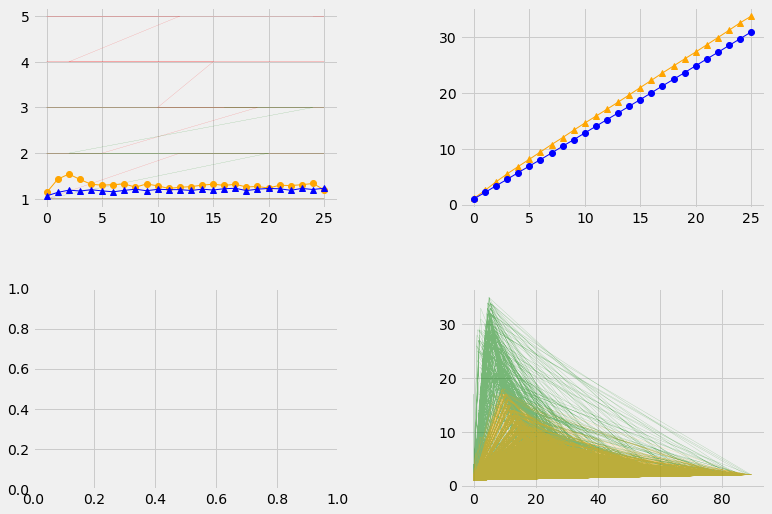

In [511]:
fig